In [14]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from scipy.stats import pearsonr
from scipy.sparse import linalg
import scipy.sparse
from scipy.linalg import solve, pinv
from scipy.signal import savgol_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc
import matplotlib.gridspec as gridspec
from functools import partial
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import time
from numpy.fft import fft2, fftshift, ifft2
from numpy import diff
import math 
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from numpy.random import default_rng
from scipy.optimize import minimize
import scipy.stats as stats
import networkx as nx

In [15]:
"""
slightly modified from networkx source code to count self-loops as +1
"""

def incidence_matrix(G, nodelist=None, edgelist=None, oriented=False, weight=None):
    import scipy as sp
    import scipy.sparse  # call as sp.sparse

    if nodelist is None:
        nodelist = list(G)
    if edgelist is None:
        if G.is_multigraph():
            edgelist = list(G.edges(keys=True))
        else:
            edgelist = list(G.edges())
    A = sp.sparse.lil_array((len(nodelist), len(edgelist)))
    node_index = {node: i for i, node in enumerate(nodelist)}
    for ei, e in enumerate(edgelist):
        (u, v) = e[:2]
        if u == v: # self loops give zero column ---> CHANGED PERSONALLY TO EQUAL 1 with the 2 lines of code below (otherwise, just 'continue')
            A[u, ei] = 1 #I set it to 1; can change to 2, which is what some conventions use. 
            A[v, ei] = 1       
            continue  
        try:
            ui = node_index[u]
            vi = node_index[v]
        except KeyError as err:
            raise nx.NetworkXError(
                f"node {u} or {v} in edgelist but not in nodelist"
            ) from err
        if weight is None:
            wt = 1
        else:
            if G.is_multigraph():
                ekey = e[2]
                wt = G[u][v][ekey].get(weight, 1)
            else:
                wt = G[u][v].get(weight, 1)
        if oriented:
            A[ui, ei] = -wt
            A[vi, ei] = wt
        else:
            A[ui, ei] = wt
            A[vi, ei] = wt
    return A.asformat("csc")

# Import data. The training data is called train_input

In [16]:

"""
if your training data (train_input) is 1D (i.e., a single time series) of shape (time), 
you must reshape it such that the array is (1, timesteps) with the following code:

train_input = train_input.reshape(1,train_input.shape[0])
"""

# exp = pd.read_csv("../data/thomas.csv",header=None)
# train_input = exp.to_numpy().transpose()[1:,:-1] # of shape (spatial dimensions x time)
# print(train_input.shape)



(3, 7500)


# Preprocessing data

In [17]:


"""
Generate train_input_fin, the portion of training data with the warmup periods discarded,
if you wish to concatenate multiple experimental datasets into one training set.

This will be used just for when we obtain the output matrix, during the final stages of training (regression).

If data is one continuous dataset, leave marker as marker=np.array(([0])). 
"""


"""
please set the following two lines.
"""
marker=np.array(([0]))            # timepoints of when warmup periods occur (i.e., the concatenation timepoints of different datasets)
warmup_period=200                 # this is T_warm in paper, sect. 5.3.1.



input_size = train_input.shape[0] # spatial dimensions of the dataset
train_input_fin=np.zeros((train_input.shape[0],train_input.shape[1]-marker.shape[0]*warmup_period))

for i in range(marker.shape[0]):
    if i!=(marker.shape[0]-1):
        for t in range(marker[i]-i*warmup_period,marker[i+1]-(i+1)*warmup_period):
            train_input_fin[:,t]=train_input[:,t+(i+1)*warmup_period]
    else:
        for t in range(marker[i]-(i)*warmup_period,train_input.shape[1]-marker.shape[0]*warmup_period):
            train_input_fin[:,t]=train_input[:,t+(i+1)*warmup_period]

            


# Set hyperparameters

In [18]:
tau=1 #timestep of phase evolution. chosen to be same as neuronal evolution
average_degree_n=10
num_nodes_n = 100

"""
if you want a normal distribution of natural frequencies, set discrete_omega0 = 0. 
if you want discrete (all modulated links share same natural frequency ), set = 1. 

For distribution, set omega0_mean and omega0_spread.
"""
discrete_omega0=1

omega0=.01
# omega0_mean=omega0
# omega0_spread=omega0/3



average_degree_links = int(num_nodes_n/2)
input_weight_n=120e-2 # max value of |W_in|. 
epsilon_1=-.2         # ε1
epsilon_2=.6          # ε2
leakage_n=0.          # leakage of nodes
spectral_radius_n=.6  # spectral radius of A_n
bias_n = 0            # bias hyperparameter of nodes
modpop=1              # fraction of links that initially have a nonzero natural frequency
modstrength=0.6       # fraction of link strength change. This is the variable m in the paper.

regularization=1e-20  # The Tikhonov regularization hyperparameter. If data is very noisy or from real-life, set it very high (~ 1e-2)


bias_n=.0
bias_phase=0          # The Sakaguchi-Kuramoto parameter, γ

data_seed = 0 #some random seed.

## From here on out, simply execute the following blocks of code if you do not wish to amend the algorithm.
# Instantiate matrices

In [19]:
A_n = sparse.random(num_nodes_n,num_nodes_n, density = average_degree_n/num_nodes_n, random_state=data_seed)
num_links=np.count_nonzero(A_n.toarray())
np.random.seed(data_seed)


# sometimes, the random matrix A_n that python generates does not have a finite spectral radius, so an execution issue arises. In that case, change the seed.

"""
Define the update equation of neuronal nodes, eq 6
"""

def advres_n(win_n,A_n,n,phi,u,leakage):

    phi_matrix=np.zeros((num_nodes_n**2)) # cast the vector of phases into same shape as adj matrix. This is equation 9 in paper.
    phi_matrix[idx_A_nonzeros]=phi #idx_A_nonzeros will be defined later; A_n must be defined first beforehand
    phi_matrix=np.reshape(phi_matrix,(num_nodes_n,num_nodes_n))

    modulation=1-(modstrength/2)*(1+(np.sin(phi_matrix))) # equation 8 in paper

    n_next = leakage*n + (1-leakage)*np.tanh((A_n.toarray()*modulation).dot(n) + np.matmul(win_n,u) + bias_vector_n) # equation 6 in paper

    return n_next



"""
Define the update equation of link phases, eq 3
"""

def forcing(n,A_phi,epsilon_1,epsilon_2,QT,phi_current):

    rx=np.multiply(A_phi.dot(np.cos(phi_current)),(1/A_phi_normalization))
    ry=np.multiply(A_phi.dot(np.sin(phi_current)),(1/A_phi_normalization))

    local_mean_phase=np.arctan2(ry,rx) #Ψ in eq 4

    q = np.sin((local_mean_phase-phi_current)+bias_phase)*(epsilon_1+epsilon_2*np.multiply(np.matmul(QT,(n+1)/2),1/QT_normalization))

    return q


def nextphi(t,n,A_phi,epsilon_1,epsilon_2,QT,phi_current,states_phi):

    phi_prev=states_phi[:,t-1]

    """
    will need to change discretization of eq 3 if including mass term (m d2Φ/dt2) in model equation.
    """
    phi_next = phi_current+tau*(omega_vector + forcing(n,A_phi,epsilon_1,epsilon_2,QT,phi_current))


    return phi_next



"""
Construct A_n
"""

A_n = sparse.random(num_nodes_n,num_nodes_n, density = average_degree_n/num_nodes_n, random_state=data_seed)
A_n = 2*A_n - A_n.ceil() #redefines A_n to range from -1 to 1
eg_n = linalg.eigs(A_n, k = 1, return_eigenvectors=False)
A_n = spectral_radius_n/np.abs(eg_n[0])*A_n


"""
Find positions of nonzero elements of A_n. This mapping is needed for eq. 9
"""
idx_A_nonzeros=np.where(np.ndarray.flatten(A_n.toarray())!=0)[0]


"""
create incidence matrix Q from A_graph (which uses networkx). A_graph will never be used again.
"""
A_graph=nx.from_numpy_array(A_n,parallel_edges=True,create_using = nx.DiGraph())
Q=incidence_matrix(A_graph,oriented=False).toarray()


"""
Normalize QT
"""

QT=Q.T
QT_normalization=np.zeros((QT.shape[0])) 
for i in range(QT.shape[0]):
    QT_normalization[i]=np.count_nonzero(QT[i])
    

"""
Construct Win
"""
qq = int(np.floor(num_nodes_n/input_size))

win_n = np.zeros((num_nodes_n,input_size))
for i in range(input_size):
    np.random.seed(i)
    ip = (-1 + 2*np.random.rand(qq));
    win_n[i*qq:(i+1)*qq,i] = input_weight_n*ip;


num_links=np.count_nonzero(A_n.toarray())

A_phi = sparse.random(num_links,num_links, density = average_degree_links/num_links, random_state=data_seed+3)
A_phi = sparse.csr_matrix.ceil(A_phi) # make it binary
A_phi_normalization=np.sum(A_phi.toarray(),axis=1) 

"""
in the case all row elements are 0, s.t. normalization causes division by 0, set normalziation coeff to some random large no. 1000
so that you'll get 0/1000 instead of 0/0
"""
if np.all(A_phi.toarray()[np.where(A_phi_normalization==0)]==0)==1: 
    A_phi_normalization[np.where(A_phi_normalization==0)]=1000


bias_vector_n = bias_n
 

    
"""
Change this block of code if you'd like a different distribution of omega0
"""

if discrete_omega0==1:
    omega_vector=sparse.random(1,num_links, density = modpop, random_state=data_seed+5)
    omega_vector=np.matrix.flatten(np.ceil(omega_vector.toarray()))*omega0
    
elif discrete_omega0==0:
    omega_vector=sparse.random(1,num_links, density = modpop, random_state=data_seed+5)
    omega_vector=np.matrix.flatten(np.ceil(omega_vector.toarray()))
    omega_vector[np.where(omega_vector!=0)[0]]=np.random.normal(loc=omega0_mean,scale=omega0_spread,size=np.where(omega_vector!=0)[0].shape[0])

    
    
"""
states_n records all node states, and is an array of shape (nodes x [timeponts-warmup_period]). 
This array is mainly used to obtain Wout later, which is why the warmup_period is removed.


note that n is just the instantaneous node states, so is a vector of shape (nodes).
"""
    
n = np.zeros((num_nodes_n))
states_n = np.zeros((num_nodes_n, train_input.shape[1]-marker.shape[0]*warmup_period))
states_phi = np.zeros((num_links, train_input.shape[1]))

"""
Randomly initialize the phases (phi)
"""
phi = np.zeros((num_links))
for i in range(num_links):
    np.random.seed(i)
    phi[i] = np.random.rand(1)[0]*2*np.pi


"""
states_phi records all phases, and is an array of shape (links x timeponts). I use this array to visualize the evolution of all link phases,
and to obtain R and <φ> later.

NOTE THAT I DID NOT REMOVE THE WARMUP PERIOD. This was just to see how the phases were reacting starting from t=0.

note that phi is just the instantaneous phase of all links, so is a vector of shape (links).
"""

states_phi=np.zeros((num_links,train_input.shape[1]))
states_phi[:,0] = phi

# Run classification (obtain (R, <φ>)) and also obtain Wout.

In [20]:
"""
We will begin training. 
"""
for i in range(marker.shape[0]):
    
    """
    First, pass the reservoir through the warmup stage at each timepoint of marker.
    """
    for t in range(warmup_period):

        n = advres_n(win_n,A_n,n,phi,train_input[:,t+marker[i]],leakage_n)  # evolve n (nodes) and phi (link phases) together.
        
        phi = nextphi(t+marker[i],n,A_phi,epsilon_1,epsilon_2,QT,phi,states_phi)
        states_phi[:,t+marker[i]+1] = phi


    """
    Set initial reservoir state and start recording the evolution of n from here on out (until the next timepoint of marker).
    These states_n are used for regression during training to obtain Wout. 
    """
    states_n[:,marker[i]-i*warmup_period] = n


    """
    Start recording all n as states_n
    """
    if i!=(marker.shape[0]-1):
        pbar=tqdm_notebook(total=marker[i+1]-(i+1)*warmup_period-1-(marker[i]-i*warmup_period))
        for t in range(marker[i]-i*warmup_period,marker[i+1]-(i+1)*warmup_period-1):
            
            states_n[:,t+1] = advres_n(win_n,A_n,states_n[:,t],phi,train_input[:,t+(i+1)*warmup_period],leakage_n)
            
            phi =nextphi(t+(i+1)*warmup_period,states_n[:,t+1],A_phi,epsilon_1,epsilon_2,QT,phi,states_phi)
            states_phi[:,t+(i+1)*warmup_period+1] = phi

            pbar.update(1)

        n = states_n[:,marker[i+1]-(i+1)*warmup_period-1] 

    else:
        pbar=tqdm_notebook(total=train_input.shape[1]-marker.shape[0]*warmup_period-1-(marker[i]-(i)*warmup_period))
        for t in range(marker[i]-(i)*warmup_period,train_input.shape[1]-marker.shape[0]*warmup_period-1):

            states_n[:,t+1] = advres_n(win_n,A_n,states_n[:,t],phi,train_input[:,t+(i+1)*warmup_period],leakage_n)
            
            phi = nextphi(t+(i+1)*warmup_period,states_n[:,t+1],A_phi,epsilon_1,epsilon_2,QT,phi,states_phi)
            states_phi[:,t+(i+1)*warmup_period+1] = phi

            pbar.update(1)


        n = states_n[:,train_input.shape[1]-marker.shape[0]*warmup_period-1]



print("Link phases generated. Now finding Wout.")

identity1 = regularization*sparse.identity(num_nodes_n)
identity2 = np.identity(train_input.shape[1]-marker.shape[0]*warmup_period)
wout=np.zeros((input_size,num_nodes_n))


thingy1= np.matmul(np.matmul(train_input_fin[:input_size],identity2),np.transpose(states_n))
# Y_target * X^T

thingy2= pinv(np.matmul(np.matmul(states_n,identity2),np.transpose(states_n))+ identity1)
wout= np.matmul(thingy1,thingy2) 
# (X X^T + βI)^(-1)


print("Wout obtained.")

  0%|          | 0/7299 [00:00<?, ?it/s]

Link phases generated. Now finding Wout.
Wout obtained.


# Obtain R, <Φ> from link phases (eq. 5)

In [21]:
Rx=np.average(np.cos(states_phi),axis=0)
Ry=np.average(np.sin(states_phi),axis=0)

R=(Rx**2+Ry**2)**(1/2) 
global_mean_phase = np.arctan2(Ry, Rx) # <Φ> 

Text(0.5, 0, 'time')

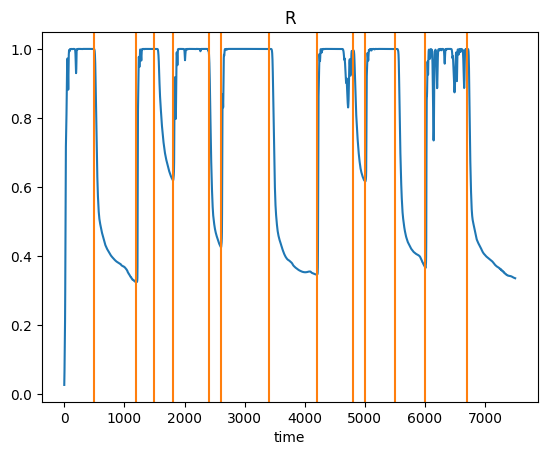

In [22]:
plt.plot(R)


changetimes=np.array((500,1200,1500,1800,2400,2600,3400,4200,4800,5000,5500,6000,6700)) # a record of when the state changes were initiated in the Thomas system

for i in range(changetimes.shape[0]):
    plt.axvline(changetimes[i],c='tab:orange') # vertical orange lines indicate state change timepoints
    
plt.title("R")
plt.xlabel("time")

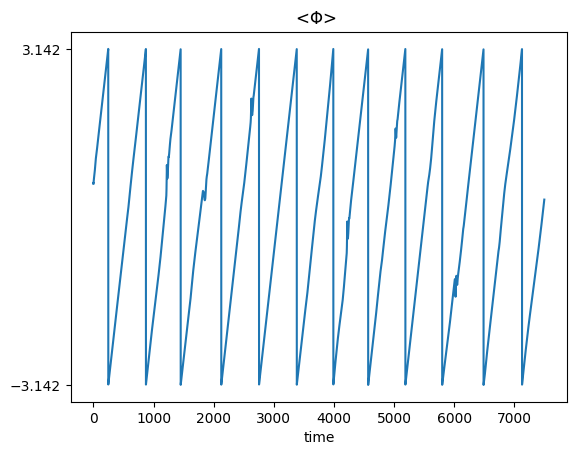

In [23]:
plt.plot(global_mean_phase)
plt.title("<Φ> ")
plt.xlabel("time")
plt.yticks([-np.pi,np.pi]);

# Prediction

To use Wout for prediction, follow the procedure outlined in sect. 5.3.2, multiplying the states of n with wout to obtain the prediction for the next timestep:

np.matmul(wout,n)

This is then used as the input to evolve n for the next timestep, i.e., in the function advres_n(win_n,A_n,n,phi,u,leakage), replace u with the prediction above. 

In [24]:

"""
Set a few more values
"""
tR0=650 # this is the timepoint in which you wish eq 14 (g) to override eq 3. 650 was an arbitrary value chosen.

"""
The following parameters determine the sensitivity to h. 

error_threshold refers to the threshold value of h desired for g=0.

error_tolerance is introduced here due to mean_phase_threshold and mean_phase_tolerance: these two are additional conditions
for which value of the mean_global_phase during test to stop g, if desired. 

Because the value of h may not be as small
during the desired range of mean_global_phase to stop g (and vice versa), an error tolerance for both conditions are introduced.

The following are just example values.
"""
mean_phase_threshold = np.pi
mean_phase_tolerance = 1e-3
error_threshold = 1e-3
error_tolerance = 1e-3


count=0 # a marker that just tracks if eq. 15 is satisfied. Do not change this line.

def nextphi_pred(t,n,A_phi,epsilon_1,epsilon_2,QT,phi_current,states_phi): #in case we need a time dependent forcing
    
    global count
    
    phi_prev=states_phi[:,t-1]     

    Rx=np.average(np.cos(phi_current),axis=0)
    Ry=np.average(np.sin(phi_current),axis=0)

    R=(Rx**2+Ry**2)**(1/2)
    global_mean_phase=np.arctan2(Ry,Rx)  

    phi_matrix=np.zeros((num_nodes_n**2))
    phi_matrix[idx_A_nonzeros]=phi_current
    phi_matrix=np.reshape(phi_matrix,(num_nodes_n,num_nodes_n))


    modulation=1-(modstrength/2)*(1+(np.sin(phi_matrix)))

    """
    Define g
    """

    if t<int(tR0):
        phi_next = phi_current+tau*(omega_vector + forcing(n,A_phi,epsilon_1,epsilon_2,QT,phi_current))


    elif t>=int(tR0):
        phi_next = phi_current+tau*omega0 # g = Ωt, with Ω = ω0
        
        if np.abs(global_mean_phase-mean_phase_threshold) < mean_phase_tolerance and count==0 and error_current<error_tolerance: 
            phi_next = phi_current 
            count = 1  # sets g=0 permanently, thereby freezing link strengths. If the user would like to try a different g, change this block of code.
        elif count == 1:
            phi_next = phi_current
        else: 
            phi_next = phi_current+omega0

    return phi_next


In [25]:
############################################################################################################


test_data = pd.read_csv("thomas_periodic_orbit.csv",header=None)
test_data = test_data.to_numpy().transpose()[1:,:-1] 


pred_warmup_period = warmup_period#define a different prediction transient length if desired


print("Now predicting...")    

length=test_data.shape[1]-pred_warmup_period

prediction = np.zeros((wout.shape[0],test_data.shape[1]))




n_test=np.zeros((num_nodes_n))
states_n_test=np.zeros((num_nodes_n,test_data.shape[1]))

phi_test=np.zeros((num_links))
states_phi_test=np.zeros((num_links,test_data.shape[1]))


"""
Instantiate random link phases again
"""
for i in range(num_links):
    np.random.seed(i+2)
    phi_test[i] = np.random.rand(1)[0]*2*np.pi
    

"""
The variable prediction includes the warm-up period as well. 
This is just in case for visualization.

Either crop the array afterwards (i.e., prediction = prediction[:,pred_warmup_period+1:], or just reference this index when plotting just the prediction
"""

# initialize first value of "prediction" array(i.e, = Wout*0)
prediction[:,0]= np.matmul(wout,n_test) # append prediction array with output y(t) = W_out x(t)




"""
Initiate warmup period again for validation dataset
"""
for t in range(pred_warmup_period):      

    error_current=np.sum(prediction[:,t]-test_data[:,t],axis=0)**2 # choosing h in eq. 15 as MSE (minimization of RMSE amounts to min of MSE). 
    # the above line is used as a condition to freeze g before the warmup period is over. If the user would like to alter the condition, edit this line.

    n_test = advres_n(win_n,A_n,n_test,phi_test,test_data[:,t],leakage_n)       
    phi_test = nextphi_pred(t,n_test,A_phi,epsilon_1,epsilon_2,QT,phi_test,states_phi_test)

    states_phi_test[:,t+1] = phi_test
    states_n_test[:,t+1] = n_test


    prediction[:,t+1] = np.matmul(wout,n_test)


pbar=tqdm_notebook(total=length-1)
for t in range(0,length-1):    

    n_test = advres_n(win_n, A_n, n_test,phi_test, \
                              prediction[:,t+pred_warmup_period], \
                              leakage_n)
    phi_test = nextphi_pred(t+pred_warmup_period,n_test,A_phi,epsilon_1,epsilon_2,QT,phi_test,states_phi_test)

    states_phi_test[:,t+pred_warmup_period+1] = phi_test
    states_n_test[:,t+pred_warmup_period+1] = n_test

    prediction[:,t+pred_warmup_period+1]=np.matmul(wout,n_test)

    pbar.update(1)



FileNotFoundError: [Errno 2] No such file or directory: 'thomas_periodic_orbit.csv'

In [ ]:
"""
View the x_output (for y_output or z_output, set prediction[0]->prediction[1] or prediction[2]
"""
plt.plot(prediction[0],linewidth=.2)
plt.title('x_output')

In [ ]:
"""
View the 2D phase portrait
"""
plt.plot(prediction[0],prediction[1],linewidth=.2)

In [ ]:
Rx_test=np.average(np.cos(states_phi_test),axis=0)
Ry_test=np.average(np.sin(states_phi_test),axis=0)

R_test=(Rx_test**2+Ry_test**2)**(1/2) 
global_mean_phase_test = np.arctan2(Ry_test, Rx_test) # <Φ> 

plt.plot(R_test)
plt.axvline(tR0, label='tR0',c='red')

plt.title("R_test")
plt.xlabel("time")
plt.legend()

In [ ]:
plt.plot(global_mean_phase_test)